In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

sns.set(style="whitegrid")

In [16]:
df = pd.read_csv("dataset.csv")
print("Основная информация по датасету:")
df.info()
print("\nПропущенные значения по колонкам:")
print(df.isnull().sum())

Основная информация по датасету:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  

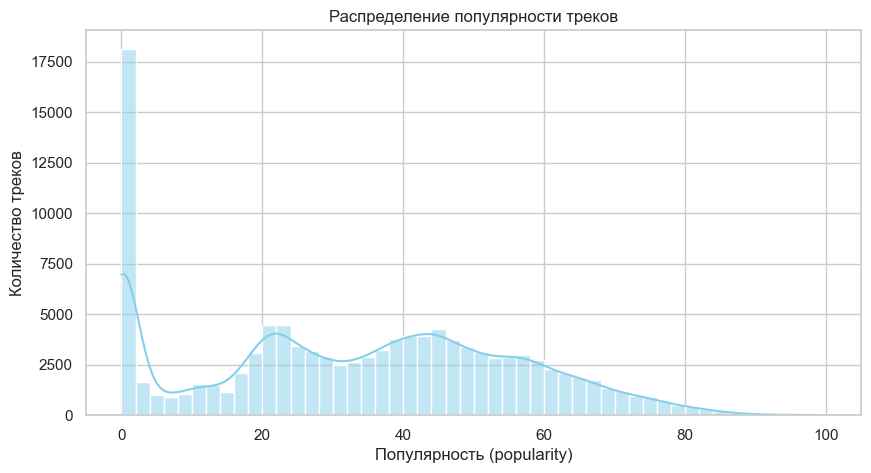

На гистограмме видно, что популярность треков имеет относительно равномерное распределение с небольшими пиками.



In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df["popularity"], bins=50, kde=True, color="skyblue")
plt.title("Распределение популярности треков")
plt.xlabel("Популярность (popularity)")
plt.ylabel("Количество треков")
plt.show()
print("На гистограмме видно, что популярность треков имеет относительно равномерное распределение с небольшими пиками.\n")

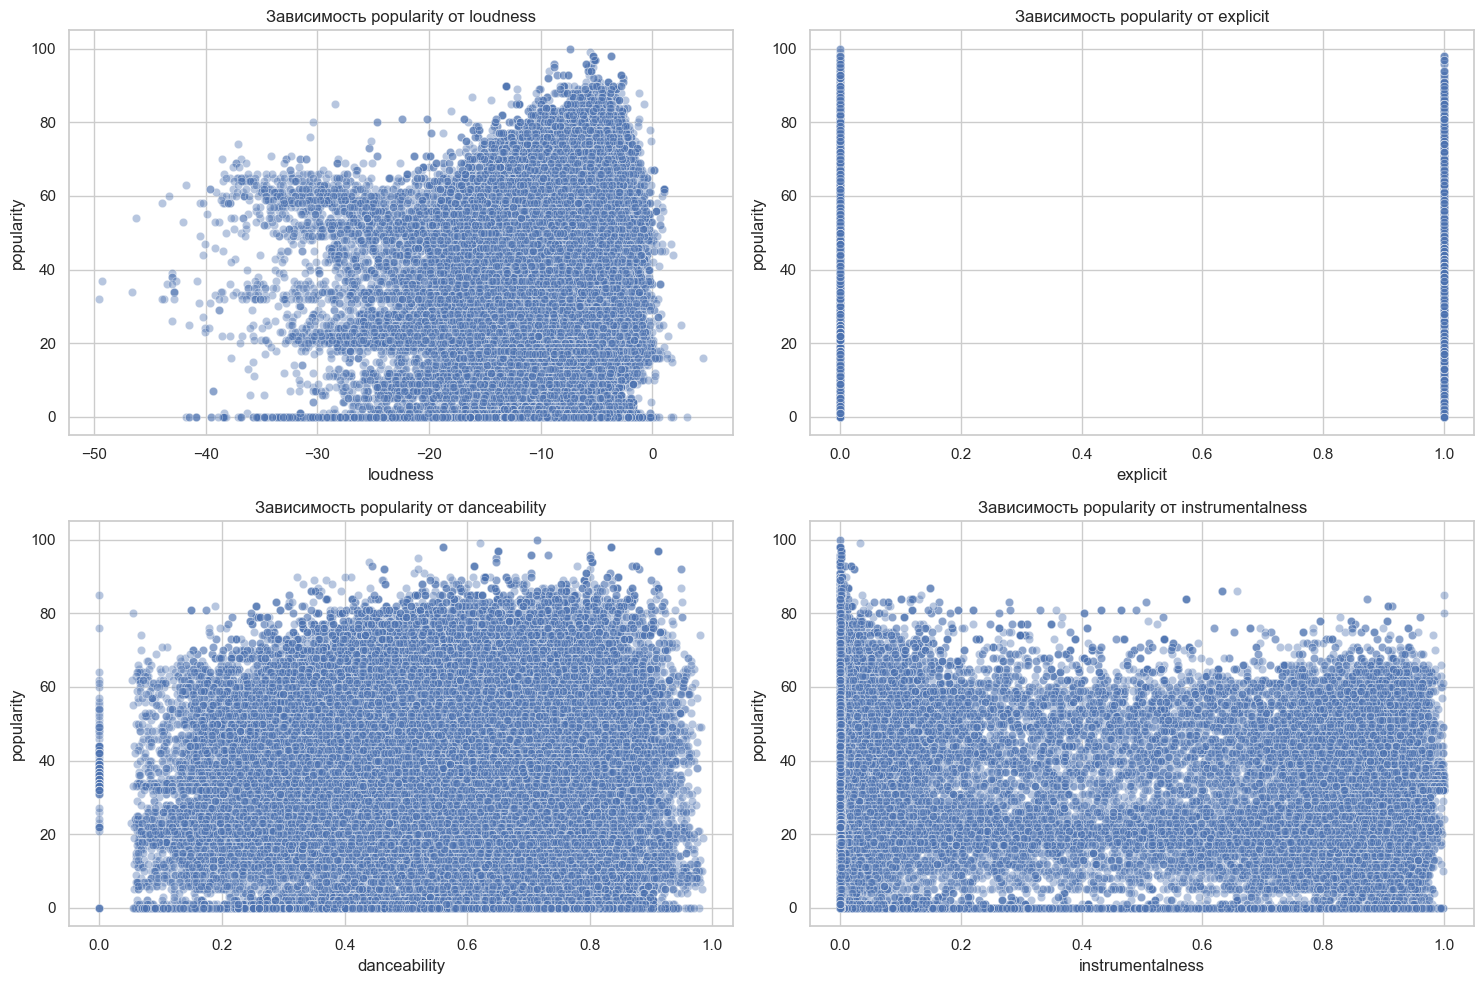

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Список признаков для визуализации
features_to_plot = ["loudness", "explicit", "danceability", "instrumentalness"]

plt.figure(figsize=(15, 10))

for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[feat], y=df["popularity"], alpha=0.4)
    plt.title(f"Зависимость popularity от {feat}")
    plt.xlabel(feat)
    plt.ylabel("popularity")

plt.tight_layout()
plt.show()


In [12]:
df["duration_min"] = df["duration_ms"] / 60000
df["energy_dance"] = df["energy"] * df["danceability"]
df["speech_instrument"] = df["speechiness"] * df["instrumentalness"]

df[["duration_min", "energy_dance", "speech_instrument", "popularity"]].corr()["popularity"]


duration_min        -0.007101
energy_dance         0.006060
speech_instrument   -0.094479
popularity           1.000000
Name: popularity, dtype: float64

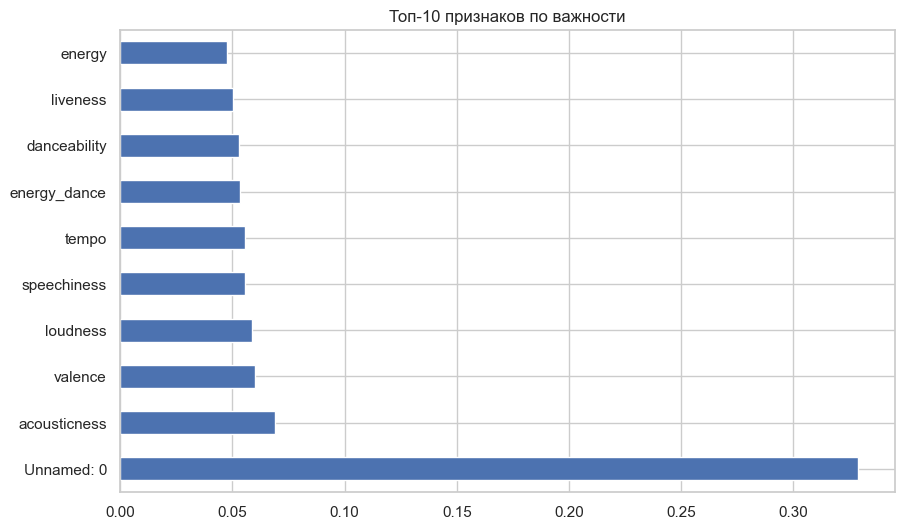

In [13]:
features = df.select_dtypes(include=["int64", "float64", "bool"]).drop(columns=["popularity"]).columns
X = df[features]
y = df["popularity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind="barh", figsize=(10, 6), title="Топ-10 признаков по важности")
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    results.append({
        "Model": name,
        "R2_mean": scores.mean(),
        "R2_std": scores.std()
    })

results_df = pd.DataFrame(results).sort_values("R2_mean", ascending=False)
results_df.reset_index(drop=True)

,Model,R2_mean,R2_std
0,Linear Regression,-0.015708,0.028537
1,Gradient Boosting,-0.271416,0.321055
2,Neural Network,-1.292726,0.745846
3,Decision Tree,-1.623207,0.895536
